In [18]:
## Import all diferent libraries
import os, sys

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

import numpy as np
import pandas as pd
import glob
import yaml
import pprint
from datetime import datetime
from scipy.stats import ttest_ind
import seaborn as sns
from matplotlib import pyplot as plt
import re
from pathlib import Path

In [6]:

##gets access to file path and gets data

paths = yaml.load(open('../../../paths.yaml', 'r'), Loader=yaml.FullLoader)

DATA_FOLDER = paths['data'] + '2021-08-post-mortem-biologic-pc/hppc/'
FILE_GROUP_REGEX_LIST = ['*cell4*hppc*.mpt*']
## sorts every file that has coin and hppc in the folder. datafolder is a path to the folder 

file_paths = [sorted(glob.glob(f'{DATA_FOLDER}{f}')) for f in FILE_GROUP_REGEX_LIST]


file_paths 



[['/Users/iaro/project/data/2021-08-post-mortem-biologic-pc/hppc/20211209_coin_lfp_cell4_hppc_1_CA4.mpt']]

In [7]:
def load_data(file_name):

    
    num_header_lines = 107

    df = pd.read_csv(file_name, header=num_header_lines, sep='\t', encoding='ISO-8859-1')
    if df.columns[0]!='mode':
        df=pd.read_csv(file_name, header=num_header_lines-1 , sep='\t', encoding='ISO-8859-1')
    if df.columns[0]!='mode':
        df=pd.read_csv(file_name, header=num_header_lines-2 , sep='\t', encoding='ISO-8859-1')
    if df.columns[0]!='mode':
        df=pd.read_csv(file_name, header=num_header_lines-3 , sep='\t', encoding='ISO-8859-1')
    if df.columns[0]!='mode':
        df=pd.read_csv(file_name, header=num_header_lines-4 , sep='\t', encoding='ISO-8859-1')
    if df.columns[0]!='mode':
        df=pd.read_csv(file_name, header=num_header_lines-5 , sep='\t', encoding='ISO-8859-1')
    if df.columns[0]!='mode':
        df=pd.read_csv(file_name, header=num_header_lines-6 , sep='\t', encoding='ISO-8859-1')
    if df.columns[0]!='mode':
        df=pd.read_csv(file_name, header=num_header_lines-7 , sep='\t', encoding='ISO-8859-1')
    if df.columns[0]!='mode':
        df=pd.read_csv(file_name, header=num_header_lines-8 , sep='\t', encoding='ISO-8859-1')
    if df.columns[0]!='mode':
        df=pd.read_csv(file_name, header=num_header_lines-9 , sep='\t', encoding='ISO-8859-1')
    return df

Text(0.5, 0, 'Time (s)')

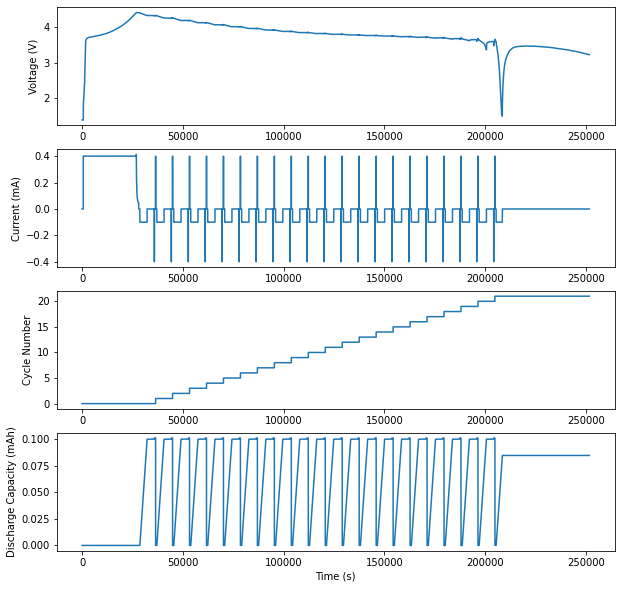

In [17]:
df = load_data(file_paths[0][0])
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(df['time/s'], df['Ecell/V'])
plt.ylabel('Voltage (V)')

plt.subplot(4, 1, 2)
plt.plot(df['time/s'], df['I/mA'])
plt.ylabel('Current (mA)')

plt.subplot(4, 1, 3)
plt.plot(df['time/s'], df['cycle number'])
plt.ylabel('Cycle Number')

plt.subplot(4, 1, 4)
plt.plot(df['time/s'], df['Q discharge/mA.h'])
plt.ylabel('Discharge Capacity (mAh)')

plt.xlabel('Time (s)')

In [39]:
## now my idea is to make a loop that goes through every path and gets all the dataframes to print the graphs
## problem- not all files have same number of rows to skip. Seems to be solved with few if statements for now

In [40]:
def VoltageCurrent(df1, file2):
    cycles_num=np.unique(df1['cycle number'])
    Time=[]
    Voltage=[]
    Current=[]
    for f in cycles_num:
        plt.figure()
        i=np.where(df1['cycle number']==f)
        plt1 =plt.subplot()
        plt2=plt1.twinx()
        Time.append(df1['time/s'].iloc[i]/60)
        Voltage.append(df1['Ecell/V'].iloc[i])
        Current.append(df1['I/mA'].iloc[i])
        plt1.plot(Time[0],Voltage[0], color= 'k')
        plt1.set_xlabel("Time(min)")
        plt1.set_ylabel("Voltage (V)")
        plt2.set_ylabel("Current (mA)")
        plt.title(file2)
        plt2.plot(Time[0],Current[0],color= 'r', ls=':')
        Time.clear()
        Voltage.clear()
        Current.clear()

In [31]:
def Resistance(df1):
    cycles_num=np.unique(df1['cycle number'])
    Time=[]
    Voltage=[]
    Current=[]
    #Resistance=[]
    for a in cycles_num:
        plt.figure()
        i=np.where(df1['cycle number']==a)
        Time.append(abs(df1['time/s'].iloc[i]/60))
        Voltage.append(df1['Ecell/V'].iloc[i])
        Current.append(df1['I/mA'].iloc[i])
        #for k in Current:
         #   if Current[0][k] !=0:
         #       Resistance.append(1000*Voltage[0][k]/Current[0][k])
         #   else:
         #       Resistance.append(0)
        plt.plot(1000*Voltage[0]/Current[0] , Time[0], linewidth=4.0 )
        plt.xlabel('Time(min)')
        plt.ylabel('Resistance($\Omega$)')
        plt.title( str(a) + ' Cycle.')
        Time.clear()
        Voltage.clear()
        Current.clear()
        #Resistance.clear()

In [34]:
def HppcResist(df1):
    cycles_num=np.unique(df1['cycle number'])
    Voltage=[]
    Current=[]
    capacity_ah=[]
    SOCxResistance=[] 
    for i in range (df1.shape[0]-1):
        curr_time= df1['time/s'].iloc[i]
        next_time= df1['time/s'].iloc[i+1]
        delta_time= next_time-curr_time
        capacity_ah.append(df1['I/mA'][i]*delta_time)
    capacity_ah= np.asarray(capacity_ah)
 #   print(sum(capacity_ah))
    for f in cycles_num:
        i=np.where(df1['cycle number']==f)
        current_df = df1[df1['cycle number'] == f]  
        for d in i[0]:
            if df1.loc[d,'I/mA'] < -0.000001 and df1.loc[d,'I/mA'] > -0.2:
                Voltage.append(df1['Ecell/V'].iloc[d])
                Current.append(df1['I/mA'].iloc[d])
## I checked that my code gets exactly what I need. I get the first and last value of my dataframe and divide by the current
## Question: when we apply negative current the SOC changes so what point to take (first/last)?       
        curent=capacity_ah[0: i[0][1]]   
        print(sum(curent)/sum(capacity_ah))
       # SOCxResistance.append(capacity_ah[i[0][0]]/np.max(capacity_ah))
        x=Voltage[-1]
        y=Voltage[0]
        z=Current[0]
        SOCxResistance.append((x-y)/z)
        Voltage.clear()
        Current.clear()
    return SOCxResistance
## code cuts dataframe in cycles for each cycle finds where current was applied, Stores current and voltage during 
## these occurences and gives back the array final resistances for each cycle 

    

In [35]:
 
for files in file_paths[0]:
    k=np.where(file_paths[0]== files)
    num_header_lines = 106
    df = load_data(files)
    Ohm=HppcResist(df)
 #   print(Ohm)
#    plt.plot(range(int(Ohm[0])), Ohm[1:-1], label=k, linestyle="",marker="o")
    



0.0
130.75572479111415
127.41536205790294
124.07515114430642
120.73441108997996
117.39424121334551
114.05417736582353
110.71407470008799
107.37338623850998
104.03302032950666
100.69261554371961
97.35208069703198
94.01150405514126
90.67105375044127
87.33052192233924
83.9899971821663
80.64946199682569
77.3092780524662
73.96882140345515
70.62846562762101
67.28800492462067
63.94773755556548
60.607362667888545
57.26693513982124
53.92650949647478
50.58616340692337
47.24536410869276
43.90446105291392
40.5639303604863
37.223597323619806
33.88297682503533
30.54239319338597
27.201760480886605
23.86110584223999
20.52045177462537
17.17982345231136
13.839240163146009
10.49839001947122
7.157915344398122
3.817134308574659


In [44]:
for file1 in file_paths[0]:
    num_header_lines = 106
    applied_current = applied_current_ma_vec[0]
    is_cathode = is_cathode_vec[0]
    name = name_vec[0]
    df = pd.read_csv(file1, header=num_header_lines, sep='\t', encoding='ISO-8859-1')
    if df.columns[0]!='mode':
        df=pd.read_csv(file1, header=num_header_lines-1 , sep='\t', encoding='ISO-8859-1')
    if df.columns[0]!='mode':
        df=pd.read_csv(file1, header=num_header_lines-2 , sep='\t', encoding='ISO-8859-1')
    if df.columns[0]!='mode':
        df=pd.read_csv(file1, header=num_header_lines-3 , sep='\t', encoding='ISO-8859-1')
    if df.columns[0]!='mode':
        df=pd.read_csv(file1, header=num_header_lines-5 , sep='\t', encoding='ISO-8859-1')
    print(df)
#    VoltageCurrent(df, file1)
#    Resistance(df)

NameError: name 'applied_current_ma_vec' is not defined